In [294]:
import torch
from torch_geometric import nn, datasets
import pytorch_lightning as L
import torch.nn.functional as F
from torcheval import metrics
import matplotlib.pyplot as plt
import scienceplots
import numpy as np
import os
from pathlib import Path

In [295]:
dataset = datasets.Planetoid("./datasets", "Cora")

In [296]:
print(f"Name: {dataset.name}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Number of edge features: {dataset.num_edge_features}")
print(f"Number of node features: {dataset.num_node_features:,}")

Name: Cora
Number of classes: 7
Number of edge features: 0
Number of node features: 1,433


In [297]:
num_nodes = dataset.x.shape[0]

In [298]:
hyper_edges = []

for node in range(num_nodes):
    adjacencies = dataset.x[node]
    hyper_edge = [node]
    edge_list = dataset.edge_index[:, dataset.edge_index[0] == node]
    for u, v in zip(edge_list[0], edge_list[1]):
        hyper_edge.append(v)
    hyper_edges.append(hyper_edge)

In [299]:
H = np.zeros((num_nodes, len(hyper_edges)))

In [300]:
for i, hyper_edge in enumerate(hyper_edges):
  for node in hyper_edge:
    H[node][i] = 1

In [301]:
nodes = []
edge_index = []

for edge in range(H.shape[1]):
  for vertex, conn in enumerate(H[:, edge]):
    if conn != 0:
      nodes.append(vertex)
      edge_index.append(edge)

In [302]:
hyper_index = torch.tensor([nodes, edge_index])

In [303]:
class GCNModel(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
    ):
        super(GCNModel, self).__init__()
        self.input = nn.conv.HypergraphConv(in_channels, hidden_channels)
        self.output = nn.conv.HypergraphConv(hidden_channels, out_channels)
        self.act = torch.nn.ELU()
        self.softmax = torch.nn.Softmax(-1)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        h = self.input(x, edge_index)
        h = self.act(h)
        h = self.output(h, edge_index)
        h = self.softmax(h)

        return h

In [304]:
class GCNTrainer(L.LightningModule):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        lr: float,
        weight_decay: float,
    ):
        super().__init__()
        self.model = GCNModel(
            in_channels,
            hidden_channels,
            out_channels,
        )
        self.lr = lr
        self.weight_decay = weight_decay
        self.criterion = torch.nn.CrossEntropyLoss()
        self.history = {
            "epochs": [],
            "loss" : [],
            "accuracy" : [],
            "val_loss" : [],
            "val_accuracy" : []
        }
        self.save_hyperparameters()

    def forward(self, x: torch.Tensor, hyper_index: torch.Tensor):
        return self.model(x, hyper_index)
    
    def _shared_eval_step(self, sample: torch.Tensor, mask: torch.Tensor):
        acc = metrics.MulticlassAccuracy()
        x, y = sample.x, F.one_hot(sample.y)
        pred = self.model(x, hyper_index.to(self.device))
        loss = self.criterion(y[mask].float(), pred[mask])
        acc.update(sample.y[mask].float(), torch.argmax(pred[mask], -1))
        
        return loss, acc.compute()

    def training_step(self, sample: torch.Tensor):
        loss, acc = self._shared_eval_step(sample, sample.train_mask)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_acc", acc, prog_bar=True, logger=True)
        self.history["loss"].append(loss.item())
        self.history["accuracy"].append(acc.item())
        return loss

    def validation_step(self, sample: torch.Tensor):
        loss, acc = self._shared_eval_step(sample, sample.val_mask)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_acc", acc, prog_bar=True, logger=True)
        self.history["val_loss"].append(loss.item())
        self.history["val_accuracy"].append(acc.item())
        return loss

    def test_step(self, sample: torch.Tensor):
        loss, acc = self._shared_eval_step(sample, sample.test_mask)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_acc", acc, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)

In [305]:
early_stop = L.callbacks.EarlyStopping(monitor="val_loss", mode="min", check_on_train_epoch_end=True, patience=100)
timer = L.callbacks.Timer()
model_checkpoint = L.callbacks.ModelCheckpoint("./logs")
callbacks = [early_stop, timer]

In [306]:
from pytorch_lightning.loggers import CSVLogger
logger = CSVLogger("logs", name="hypergraph")

In [307]:
trainer_module = GCNTrainer(
    in_channels=dataset.num_features,
    hidden_channels=16,
    out_channels=dataset.num_classes,
    lr=0.005,
    weight_decay=0.0003,
)

trainer = L.Trainer(
    accelerator="gpu",
    precision="16-mixed",
    max_epochs=1000,
    num_sanity_val_steps=0,
    val_check_interval=1,
    callbacks=callbacks,
    logger=logger,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


In [308]:
trainer_module

GCNTrainer(
  (model): GCNModel(
    (input): HypergraphConv(1433, 16)
    (output): HypergraphConv(16, 7)
    (act): ELU(alpha=1.0)
    (softmax): Softmax(dim=-1)
  )
  (criterion): CrossEntropyLoss()
)

In [309]:
trainer.fit(trainer_module, dataset, dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | GCNModel         | 23.1 K
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
23.1 K    Trainable params
0         Non-trainable params
23.1 K    Total params
0.092     Total estimated model params size (MB)


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s, v_num=8, train_loss=1.170, train_acc=1.000, val_loss=1.420, val_acc=0.778]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s, v_num=8, train_loss=1.170, train_acc=1.000, val_loss=1.420, val_acc=0.778]


In [310]:
print(f"Train time: {timer.time_elapsed('train'):.3f}s")
print(f"Validate time: {timer.time_elapsed('validate'):.3f}s")
print(f"Test time: {timer.time_elapsed('test'):.3f}s")

Train time: 103.625s
Validate time: 0.047s
Test time: 0.000s


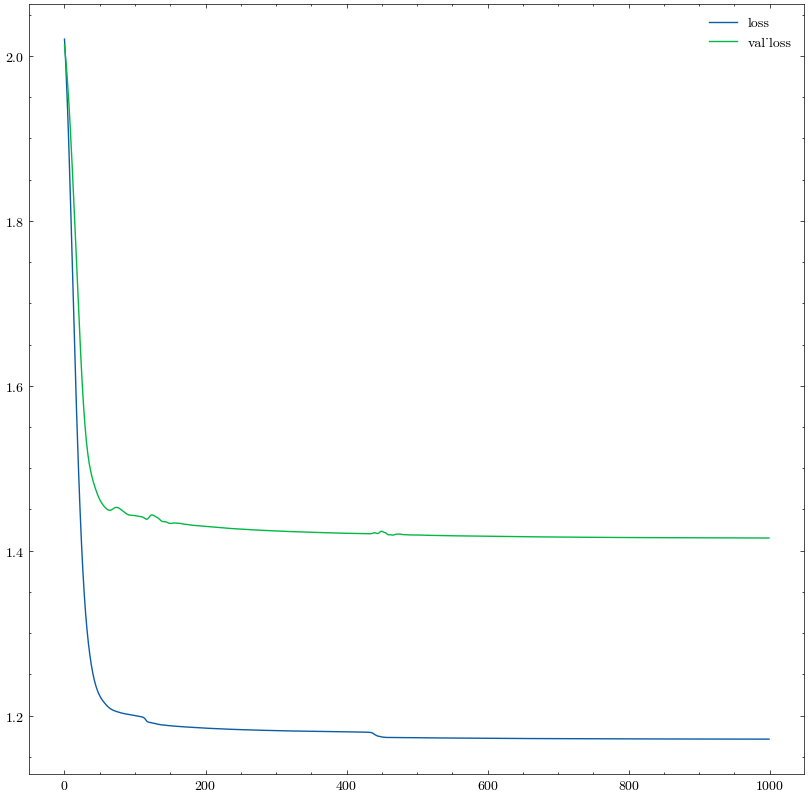

In [311]:
plt.style.use(["science", "no-latex"])
plt.figure(figsize=(10, 10))

plt.plot(range(trainer_module.current_epoch), trainer_module.history["loss"])
plt.plot(range(trainer_module.current_epoch), trainer_module.history["val_loss"])
plt.legend(["loss", "val_loss"])

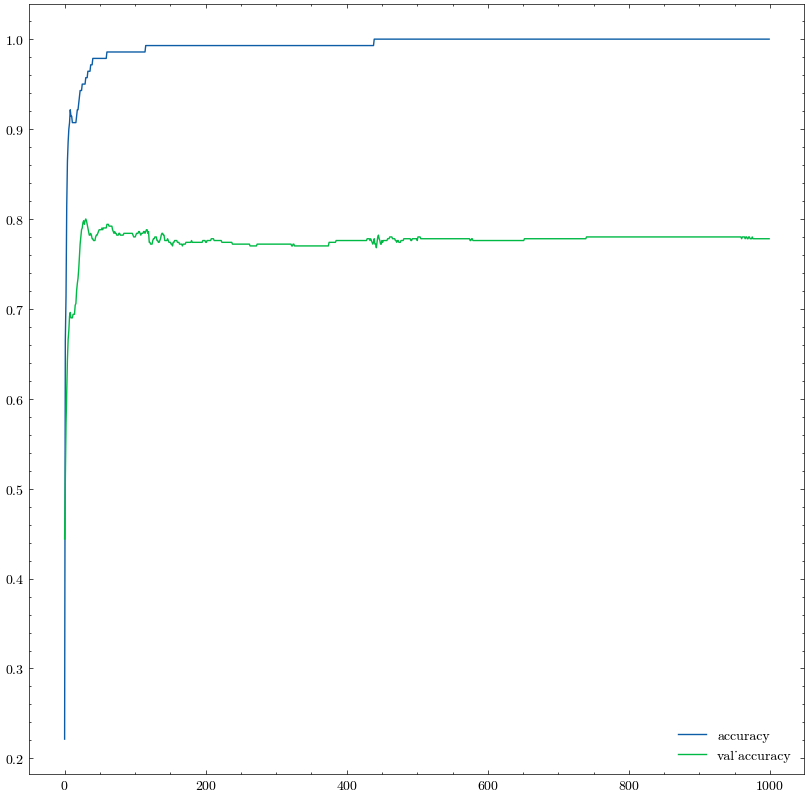

In [312]:
plt.style.use(["science", "no-latex"])
plt.figure(figsize=(10, 10))

plt.plot(range(trainer_module.current_epoch), trainer_module.history["accuracy"])
plt.plot(range(trainer_module.current_epoch), trainer_module.history["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])

In [313]:
paths = sorted(Path("./logs/hypergraph").iterdir(), key=os.path.getmtime, reverse=True)

ckpt_path = os.path.join(paths[0], "checkpoints")
ckpt_file = os.listdir(ckpt_path)[0]
ckpt_full_path = os.path.join(ckpt_path, ckpt_file)

In [314]:
ckpt_full_path

'logs\\hypergraph\\version_8\\checkpoints\\epoch=999-step=1000.ckpt'

In [315]:
model = GCNTrainer.load_from_checkpoint(ckpt_full_path)

In [317]:
trainer.test(model, dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7969999313354492
        test_loss           1.3932846784591675
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.3932846784591675, 'test_acc': 0.7969999313354492}]